### Data Shifting Experiment

### COCO - QA
* [Review](https://arxiv.org/abs/1610.01465)

In [1]:
%cd ..

/home/datascience/Data Fusion


In [2]:
import os
import numpy as np
import pandas as pd

from src.classifiers import preprocess_data, process_labels, split_data
from src.classifiers import VQADataset
from torch.utils.data import DataLoader
from src.classifiers import train_early_fusion, train_late_fusion

from utils import normalize_embeddings, modify_and_normalize_embeddings, visualize_embeddings

In [3]:
PATH = 'Embeddings_vlm/coco-qa/'
FILE = 'embeddings_clip.csv'
DATASET = 'COCO-QA'

batch_size = 64

multilabel = False

num_epochs = 50

In [4]:
df = pd.read_csv(os.path.join(PATH, FILE))
df.drop(columns=['image_id'], inplace=True)
df.head()

,questions,answers,types,split,image_embedding_0,image_embedding_1,image_embedding_2,image_embedding_3,image_embedding_4,image_embedding_5,...,text_embedding_502,text_embedding_503,text_embedding_504,text_embedding_505,text_embedding_506,text_embedding_507,text_embedding_508,text_embedding_509,text_embedding_510,text_embedding_511
0,what is using umbrellas as a central theme,sculpture,0,train,-0.002133,0.026865,-0.009941,-0.000407,-0.001535,0.043021,...,0.013656,0.006139,0.018542,-0.027902,-0.010581,0.001189,-0.018054,0.006616,0.039209,-0.052176
1,what walks toward the rope perimeter fence,elephant,0,train,-0.037488,-0.025273,0.021552,0.056967,0.010018,-0.042177,...,-0.007028,-0.002520,0.001875,-0.028708,0.016469,-0.011620,-0.010105,0.034845,-0.021513,0.029620
2,what is the color of the horses,brown,2,train,-0.050188,0.034539,0.008536,0.017248,0.027789,-0.020876,...,0.009025,0.000571,-0.022466,0.010579,-0.025592,0.034800,-0.007262,0.010370,-0.009308,0.008854
3,where is the black cat laying down,sink,3,train,-0.003502,0.007140,0.014187,0.052844,0.012376,-0.005956,...,-0.012388,0.034164,0.007408,0.029274,-0.018850,-0.007775,0.033192,0.001180,-0.041182,0.004494
4,what is the color of the character,purple,2,train,0.046207,0.050791,-0.010908,0.025887,-0.029377,-0.023032,...,-0.009319,-0.034246,0.002291,-0.004910,-0.025292,0.012616,-0.017789,-0.012675,-0.004709,0.028756


In [5]:
# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column]
image_columns = [column for column in df.columns if 'image' in column]
label_columns = 'answers'
output_size = len(pd.unique(df[label_columns]))

### Run Experiments

##################################################  Shift -1  ##################################################


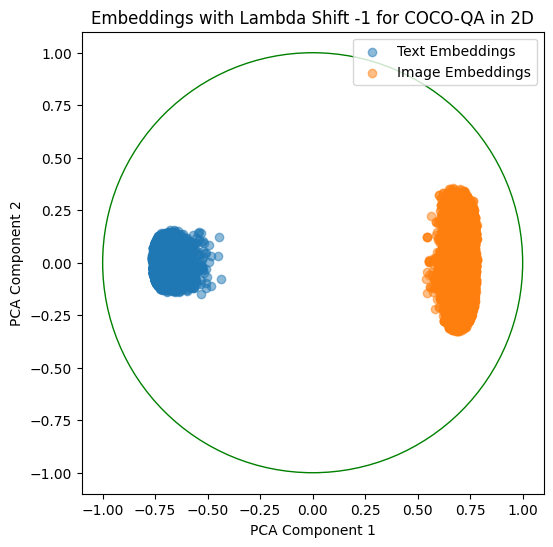

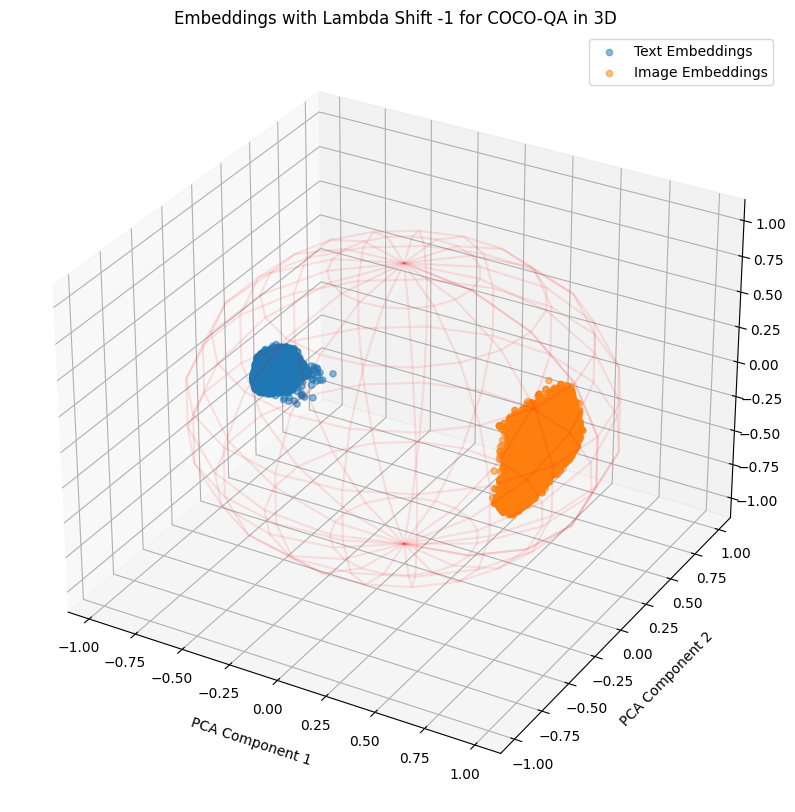

Train Shape: (78736, 1028)
Test Shape: (38948, 1028)
Training Early Fusion Model:
The number of parameters of the model are: 186926
Average Training Time per Epoch: 4.37 seconds
Total Training Time per Epoch: 131.03 seconds
Average Inference Time per Epoch: 4.93 seconds
Total Inference Time per Epoch: 147.87 seconds


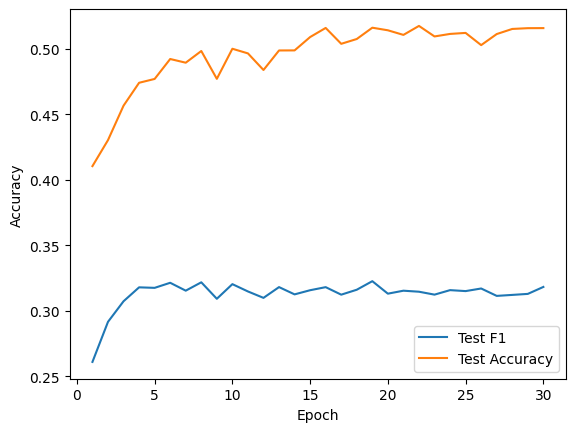

Best Accuracy: {'Acc': 0.5176132278936018, 'F1': 0.31463541449953675, 'Epoch': 22}
Best Macro-F1: {'Acc': 0.5162524391496354, 'F1': 0.32268550488991504, 'Epoch': 19}
Training Late Fusion Model:
The number of parameters of the model are: 121390


In [ ]:
# Assuming df is your DataFrame
lambda_shift_values = [-1, -0.5, 0, 0.5, 1]  # Negative values bring embeddings closer, positive values push them apart

# Normalize initial embeddings
df[text_columns] = normalize_embeddings(df[text_columns].values)
df[image_columns] = normalize_embeddings(df[image_columns].values)

# Dataframe with shifted values:
df_shifted = df.copy()

results = {}

for lambda_shift in lambda_shift_values:
    
    print('#'*50, f' Shift {lambda_shift} ', '#'*50)
    
    # Extract embeddings
    text_embeddings = df[text_columns].values
    image_embeddings = df[image_columns].values
    
    # Modify and normalize embeddings
    text_embeddings_shifted, image_embeddings_shifted = modify_and_normalize_embeddings(text_embeddings, image_embeddings, lambda_shift)
    
    # Update DataFrame with shifted embeddings
    df_shifted[text_columns] = text_embeddings_shifted
    df_shifted[image_columns] = image_embeddings_shifted
    
    # Visualize shifted embeddings
    visualize_embeddings(text_embeddings_shifted, image_embeddings_shifted, f'Embeddings with Lambda Shift {lambda_shift} for {DATASET}', lambda_shift, DATASET)
    
    # Split the data
    train_df, test_df = split_data(df_shifted)
    
    
    # Process and one-hot encode labels for training set
    train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
    test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)

    train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
    test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    text_input_size = len(text_columns)
    image_input_size = len(image_columns)

    ### Models:

    # Train early fusion model
    print("Training Early Fusion Model:")
    accuracy, precision, recall, f1, best = train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=num_epochs, multilabel=multilabel, report=True, V=False)
    print(f"Best Accuracy: {best['Acc']}")
    print(f"Best Macro-F1: {best['Macro-F1']}")
    
    results[f"early_({lambda_shift})"] = best
    
    # Train late fusion model
    print("Training Late Fusion Model:")
    accuracy, precision, recall, f1, best = train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=num_epochs, multilabel=multilabel, report=True, V=False)
    print(f"Best Accuracy: {best['Acc']}")
    print(f"Best Macro-F1: {best['Macro-F1']}")
    
    results[f"late_({lambda_shift})"] = best

In [ ]:
print('Results Early Fusion: ')
for lambda_shift in lambda_shift_values:
    print(f'Shift = {lambda_shift}')
    print(f"Best Accuracy: {results[f'early_({lambda_shift})']['Acc']}")
    print(f"Best F1: {results[f'early_({lambda_shift})']['Macro-F1']}")
    
print('Results Late Fusion: ')
for lambda_shift in lambda_shift_values:
    print(f'Shift = {lambda_shift}')
    print(f"Best Accuracy: {results[f'late_({lambda_shift})']['Acc']}")
    print(f"Best F1: {results[f'late_({lambda_shift})']['Macro-F1']}")